# BikeSales Modelling

In [21]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')



In [30]:
#Load the data and infer the date format for the date features

df = pd.read_csv('clean_sport2.csv', 
                  parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                  infer_datetime_format=True)
df.head()
sport = df

In [31]:
# sport.drop(['Body','Drive_Type','Fuel_Type','Gear_Change_Method','Gear_Type',
#             'Network_ID','Registration_Plate','URL','Windscreen'], axis=1, inplace=True)

# SELECT INDIVIDUAL FEATURES - we want to simplify the model

In [32]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [33]:
def add_dummy_variables(df, categorical_features):
    
    additional = pd.get_dummies(df[categorical_features])
    df[additional.columns] = additional
    return df.drop(categorical_features, axis=1)

def feature_plot(model,X,top=10):
    
    feats_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['FeatureImportance'])
    feats_imp = feats_imp.sort_values('FeatureImportance', ascending=False)[:top]

    feats_imp.plot(kind='barh', figsize=(12,6), legend=False)
    plt.title('Feature Importance from XgBoost Classifier')
    sns.despine(left=True, bottom=True)
    plt.gca().invert_yaxis()
    
def plot_accuracy_predictions(y_test, pred):
    fig, ax = plt.subplots(figsize=(12,10))
    ax.scatter(y_test,pred)
    ax.plot([y_test(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=0.8)
    ax.set_xlabel('Measured');
    ax.set_ylabel('Predicted');
    ax.set_title('Accuracy of Predictions');
    

In [34]:
print (sport.shape)
sport_numbers = sport.select_dtypes(include='number')
print (sport_numbers.shape)



(2555, 69)
(2555, 27)


In [35]:
list(sport.columns)

['Bore',
 'Compression_Ratio',
 'Cylinders',
 'Dry_Weight',
 'Engine_Description',
 'Front_Brake_Diameter',
 'Front_Suspension_Travel',
 'Fuel_Reserve_Capacity',
 'Fuel_Tank_Capacity',
 'Ground_Clearance',
 'Height',
 'Kilometers',
 'Length',
 'Maximum_Power',
 'Maximum_Power_RPM',
 'Oil_Capacity',
 'Price',
 'Rear_Brake_Diameter',
 'Rear_Suspension_Travel',
 'Seat_Height',
 'Stroke',
 'Trail',
 'Warranty_in_Months_from_First_Registration',
 'Wheelbase',
 'Width',
 'Age',
 'Time_to_Sale',
 'ABS',
 'Bike',
 'Cam_Type',
 'Carburettor',
 'Charging_Method',
 'Clutch_Type',
 'Colour',
 'Cooling',
 'Country_of_Origin',
 'Engine_Config',
 'Engine_Immobiliser',
 'Engine_Type',
 'Exhaust_Config',
 'First_Seen',
 'Frame_Material',
 'Front_Brake_Caliper(s)',
 'Front_Brake_Description',
 'Front_Suspension',
 'Ignition',
 'Induction_System',
 'Last_Modified',
 'Last_Seen',
 'Learner_Approved',
 'Linked_Braking_System',
 'Lock_Type',
 'Rear_Brake_Caliper(s)',
 'Rear_Brake_Description',
 'Rear_Suspen

In [36]:
sport.head()

,Bore,Compression_Ratio,Cylinders,Dry_Weight,Engine_Description,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Reserve_Capacity,Fuel_Tank_Capacity,Ground_Clearance,...,Side_Stand,Side_Stand_Start_Inhibitor,Starter,Swingarm_Type,Traction_Control,Warranty_KMs,Wheel_Type,Seller,Brand,Model
0,74.0,11.0,4.0,170.0,929.0,290.235019,157.464301,4.000000,18.0,138.0,...,Yes,No,Electric,Dual Sided,No,No,Spoke,Private,Honda,Cbr900rr fireblade 929
1,62.0,11.0,2.0,152.0,250.0,290.000000,120.000000,3.440919,18.0,130.0,...,Standard,No,Electric,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r ex250j
2,62.0,11.0,2.0,130.0,250.0,290.000000,120.000000,3.440919,18.0,135.0,...,Standard,No,Electric,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r special edition
3,62.0,11.0,2.0,152.0,250.0,290.000000,120.000000,3.440919,18.0,130.0,...,Standard,No,Electric,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r ex250j
4,62.0,11.0,2.0,152.0,250.0,290.000000,120.000000,3.440919,18.0,130.0,...,Standard,No,Electric,Dual Sided,No,No,Spoke,Dealer,Kawasaki,Ninja 250r ex250j


In [37]:
numerical_features = list(df.select_dtypes(include='number').columns)
categorical_features = list(df.select_dtypes(exclude='number').columns)

# categorical_features = ['Bike', 'Body', 'Colour', 'Cooling', 'Country_of_Origin', 
#                         'Engine_Config', 'Fuel_Type', 'State', 'Suburb', 'Seller', 
#                         'Brand', 'Model'] 

#categorical_features = ['Bike', 'Body', 'Brand', 'Model', 'Seller']

In [38]:
sport = add_dummy_variables(sport, categorical_features)

In [39]:
sport.head()

,Bore,Compression_Ratio,Cylinders,Dry_Weight,Engine_Description,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Reserve_Capacity,Fuel_Tank_Capacity,Ground_Clearance,...,Model_f4 1000 abs,Model_f4 1000s corse,Model_f4 312 r 1000,Model_f4 312 r 1000 11,Model_f4 750 s,Model_f4 750 s f4s 11,Model_f4 r,Model_f4 rr,Model_f4 rr 1000,Model_f4ago 1000
0,74.0,11.0,4.0,170.0,929.0,290.235019,157.464301,4.000000,18.0,138.0,...,0,0,0,0,0,0,0,0,0,0
1,62.0,11.0,2.0,152.0,250.0,290.000000,120.000000,3.440919,18.0,130.0,...,0,0,0,0,0,0,0,0,0,0
2,62.0,11.0,2.0,130.0,250.0,290.000000,120.000000,3.440919,18.0,135.0,...,0,0,0,0,0,0,0,0,0,0
3,62.0,11.0,2.0,152.0,250.0,290.000000,120.000000,3.440919,18.0,130.0,...,0,0,0,0,0,0,0,0,0,0
4,62.0,11.0,2.0,152.0,250.0,290.000000,120.000000,3.440919,18.0,130.0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
sport_df = sport.select_dtypes(include='number')

target = 'Price'
features = list(set(sport_df.columns) - set([target]))
#features = ['Age']

sc = StandardScaler()
sc.fit(sport_df[features])
s = sc.transform(sport_df[features])
scaleSport = pd.DataFrame(s,columns=features)

X = scaleSport[features]
y = sport_df[target]


#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [41]:
scaleSport.describe()

,Bike_CBR600RR MY09 Road Manual 6sp,Colour_purple,Exhaust_Config_2 into 1,Cooling_Liquid & Fan,Registration_Expiry_01/04/2020,Model_Ninja 300 special edition,Starter_Electric,Bike_Ninja ZX-6R Road Manual 6sp 636cc,Side_Stand_Standard,Model_Ninja zx 6r 636,...,Bike_F3 800 RC Road Manual 6sp 800cc,Bike_Ninja 400 Special Edition MY19 Road Manual 6sp,Carburettor_Carburettor,Bike_GSX-R1000 GSX-R1000 - 988cc,Registration_Expiry_01/04/2017,Carburettor_Constant velocity,Engine_Config_Inline,Bike_Daytona 675 R MY12 Road Manual 6sp,Bike_Daytona 675 R,Bike_Ninja 250R Special Edition MY12 Road Manual 6sp
count,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,...,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03,2.555000e+03
mean,1.557680e-16,-4.357028e-16,-3.867313e-16,9.142502e-17,1.014507e-15,-1.239224e-15,1.172839e-15,1.034669e-15,6.026056e-16,-6.279495e-16,...,-2.383422e-16,1.529951e-16,1.430564e-15,7.747065e-16,1.474359e-16,-2.548038e-15,-8.739259e-16,4.389183e-16,6.167278e-16,1.143826e-15
std,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,...,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00,1.000196e+00
min,-1.978744e-02,-3.428627e-02,-5.576098e-01,-1.615686e-01,-9.103457e-02,-9.319524e-02,-2.258318e+01,-9.103457e-02,-1.173347e+00,-5.241424e-02,...,-2.798914e-02,-1.978744e-02,-5.241424e-02,-4.428074e-02,-1.978744e-02,-2.703304e-01,-1.076923e+00,-3.428627e-02,-6.575636e-02,-2.798914e-02
25%,-1.978744e-02,-3.428627e-02,-5.576098e-01,-1.615686e-01,-9.103457e-02,-9.319524e-02,4.428074e-02,-9.103457e-02,-1.173347e+00,-5.241424e-02,...,-2.798914e-02,-1.978744e-02,-5.241424e-02,-4.428074e-02,-1.978744e-02,-2.703304e-01,-1.076923e+00,-3.428627e-02,-6.575636e-02,-2.798914e-02
50%,-1.978744e-02,-3.428627e-02,-5.576098e-01,-1.615686e-01,-9.103457e-02,-9.319524e-02,4.428074e-02,-9.103457e-02,8.522625e-01,-5.241424e-02,...,-2.798914e-02,-1.978744e-02,-5.241424e-02,-4.428074e-02,-1.978744e-02,-2.703304e-01,9.285714e-01,-3.428627e-02,-6.575636e-02,-2.798914e-02
75%,-1.978744e-02,-3.428627e-02,-5.576098e-01,-1.615686e-01,-9.103457e-02,-9.319524e-02,4.428074e-02,-9.103457e-02,8.522625e-01,-5.241424e-02,...,-2.798914e-02,-1.978744e-02,-5.241424e-02,-4.428074e-02,-1.978744e-02,-2.703304e-01,9.285714e-01,-3.428627e-02,-6.575636e-02,-2.798914e-02
max,5.053712e+01,2.916619e+01,1.793369e+00,6.189321e+00,1.098484e+01,1.073016e+01,4.428074e-02,1.098484e+01,8.522625e-01,1.907878e+01,...,3.572814e+01,5.053712e+01,1.907878e+01,2.258318e+01,5.053712e+01,3.699177e+00,9.285714e-01,2.916619e+01,1.520765e+01,3.572814e+01


In [42]:


def adjusted_r2(r2, n, k):
    return 1 - (1-r2)*((n-1)/(n-k-1)) 



def run_model(df, features, y):

    X = df[list(set(df.select_dtypes(include='number').columns) - set('Price'))]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)


    models = []

    models.append(("LassoCV",LassoCV(cv=5)))
    models.append(("LinearRegression",LinearRegression()))
    models.append(("PassiveAggressiveRegressor",PassiveAggressiveRegressor()))
    models.append(("RidgeCV",RidgeCV(cv=5)))
    models.append(("Bagging",BaggingRegressor()))
    models.append(("SVR",SVR()))

    results = []
    names = []
    n,k = X_train[features].shape

    for name, model in models:
        score = cross_val_score(model, X_train[features], y_train,  cv=5)
        
        result = adjusted_r2(score,n,k)
        #result = score
        names.append(name)
        results.append(result)

    for i in range(len(names)):
        print(names[i],results[i].mean())
    

    

In [43]:
bike_cols = [col for col in sport_df.columns if 'Bike' in col]
brand_cols = [col for col in sport_df.columns if 'Brand' in col]
model_cols = [col for col in sport_df.columns if 'Model' in col]
niave_feature = ['Kilometers','Age']

In [44]:
#run_model(scaleSport, niave_feature, sport_df[target])

In [45]:
run_model(sport_df, niave_feature, sport_df[target])

LassoCV 0.10980277819450399
LinearRegression 0.12555495127724445
PassiveAggressiveRegressor -7740.137040943198
RidgeCV 0.12555433578782826
Bagging 0.04129522825924352
SVR -0.12117913585670878


In [46]:
#run_model(scaleSport, bike_cols, sport_df[target])

In [47]:
run_model(sport_df, bike_cols, sport_df[target])

LassoCV 0.7084228026179725
LinearRegression -1.3881992397439972e+25
PassiveAggressiveRegressor -0.6764575765023041
RidgeCV 0.7204110102221719
Bagging 0.5624577196623014
SVR -0.33406803203486096


In [48]:
#run_model(scaleSport, brand_cols, sport_df[target])

In [49]:
run_model(sport_df, brand_cols, sport_df[target])

LassoCV 0.3671031454105404
LinearRegression -3.800209241128709e+23
PassiveAggressiveRegressor -0.4028246464756073
RidgeCV 0.3661082422023708
Bagging 0.3684013150436476
SVR -0.12534868322892295


In [50]:
#run_model(scaleSport, model_cols, sport_df[target])

In [51]:
run_model(sport_df, model_cols, sport_df[target])

LassoCV 0.7531863349851358
LinearRegression -2.729344360411598e+24
PassiveAggressiveRegressor -0.5413557402207004
RidgeCV 0.7587249400357449
Bagging 0.7306862087299921
SVR -0.22768801806748287


In [53]:
## Use Forward Feature Selection to pick a good model
X = sport_df[features]
y = sport_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

# start with no predictors
included = []
# keep track of model and parameters
best = {'feature': '', 'r2': 0, 'a_r2': 0}
# create a model object to hold the modelling parameters
model = RidgeCV(cv=5) 
# get the number of cases in the test data
n = X_test.shape[0]

while True:
    changed = False
    
    # list the features to be evaluated
    excluded = list(set(features) - set(included))
    
    
    # for each remaining feature to be evaluated
    for new_column in excluded:
        
        # fit the model with the Training data
        fit = model.fit(X_train[included + [new_column]], y_train) # fit a model; consider which predictors should be included
        # calculate the score (R^2 for Regression)
        r2 = model.score(X_test[included + [new_column]], y_test) # calculate the score
        # number of predictors in this model
        k = len(included + [new_column]) + 1
        # calculate the adjusted R^2
        adjusted_r = adjusted_r2(r2,n,k) 

   
        # if model improves
        if adjusted_r > best['a_r2']:
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r}
            # flag that found a better model
            changed = True
   
    # if found a better model after testing all remaining features
    if changed:
        # update control details
        included.append(best['feature'])
        excluded = list(set(excluded) - set(best['feature']))
        print('Added feature %-4s with R^2 = %.3f and adjusted R^2 = %.3f' % 
              (best['feature'], best['r2'], best['a_r2']))
    else:
        # terminate if no better model
        break

print('')
print('Resulting features:')
print(', '.join(included))

Added feature Maximum_Power with R^2 = 0.547 and adjusted R^2 = 0.546
Added feature Kilometers with R^2 = 0.683 and adjusted R^2 = 0.682
Added feature Traction_Control_No with R^2 = 0.750 and adjusted R^2 = 0.749
Added feature Bore with R^2 = 0.778 and adjusted R^2 = 0.777
Added feature Time_to_Sale with R^2 = 0.793 and adjusted R^2 = 0.791
Added feature Age  with R^2 = 0.803 and adjusted R^2 = 0.802
Added feature Cylinders with R^2 = 0.812 and adjusted R^2 = 0.810
Added feature Model_Yzf r1m with R^2 = 0.818 and adjusted R^2 = 0.816
Added feature Cam_Type_DOHC (Double Over Head Cam) with R^2 = 0.825 and adjusted R^2 = 0.822
Added feature Model_Ninja zx 10r krt abs replica with R^2 = 0.831 and adjusted R^2 = 0.828
Added feature Colour_none with R^2 = 0.837 and adjusted R^2 = 0.834
Added feature Ignition_Digital with R^2 = 0.841 and adjusted R^2 = 0.838
Added feature Side_Stand_Start_Inhibitor_Standard with R^2 = 0.845 and adjusted R^2 = 0.842
Added feature Model_1199 panigale r abs wit

Added feature Model_1098 s with R^2 = 0.926 and adjusted R^2 = 0.915
Added feature Seating_Position_Forward with R^2 = 0.926 and adjusted R^2 = 0.915
Added feature Model_S 1000 rr m sport with R^2 = 0.926 and adjusted R^2 = 0.915
Added feature Bike_999S Road Manual 6sp 999cc with R^2 = 0.927 and adjusted R^2 = 0.915
Added feature Brand_Hyosung with R^2 = 0.927 and adjusted R^2 = 0.915
Added feature Model_Cbr954rr fireblade with R^2 = 0.927 and adjusted R^2 = 0.915
Added feature Rear_Suspension_Hydraulic with R^2 = 0.927 and adjusted R^2 = 0.915
Added feature Model_Yzf r6sp with R^2 = 0.927 and adjusted R^2 = 0.915
Added feature Colour_white with R^2 = 0.927 and adjusted R^2 = 0.915
Added feature Model_Ninja zx 10r abs with R^2 = 0.928 and adjusted R^2 = 0.915
Added feature Front_Brake_Caliper(s)_Four Piston with R^2 = 0.928 and adjusted R^2 = 0.915
Added feature Model_Yzf r1 with R^2 = 0.928 and adjusted R^2 = 0.915
Added feature Exhaust_Config_4 into 2 with R^2 = 0.928 and adjusted R^

In [56]:
len(included)

127

In [57]:
model = RidgeCV(cv=5)
model.fit(X_train[included], y_train)
model.score(X_test[included], y_test)

0.9304581071244014

In [58]:
model.fit(sport_df[included],sport_df[target])
predictions = model.predict(sport_df[included])
sport_df['Predicted_Price'] = predictions

In [59]:
sport_df['Price_ratio'] = sport_df['Price'] / sport_df['Predicted_Price']

sport_df['Deal_type'] = 'Dont Bother'
sport_df['Deal_type'][sport_df['Price_ratio'] > 0.9] = 'Negotiate'
sport_df['Deal_type'][sport_df['Price_ratio'] > 0.8] = 'Good Deal'
sport_df['Deal_type'][sport_df['Price_ratio'] > 0.75] = 'Great Deal'
sport_df['Deal_type'][sport_df['Price_ratio'] > 0.5] = 'Its a steel'


In [60]:
def scatter(data,x,y,hue=None,title='',figsize=(12,10)):
    ax = plt.figure(figsize=figsize)
    sns.scatterplot(x=x,y=y,hue=hue,data=data);
    plt.title(title,fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.ylim(0,40000)


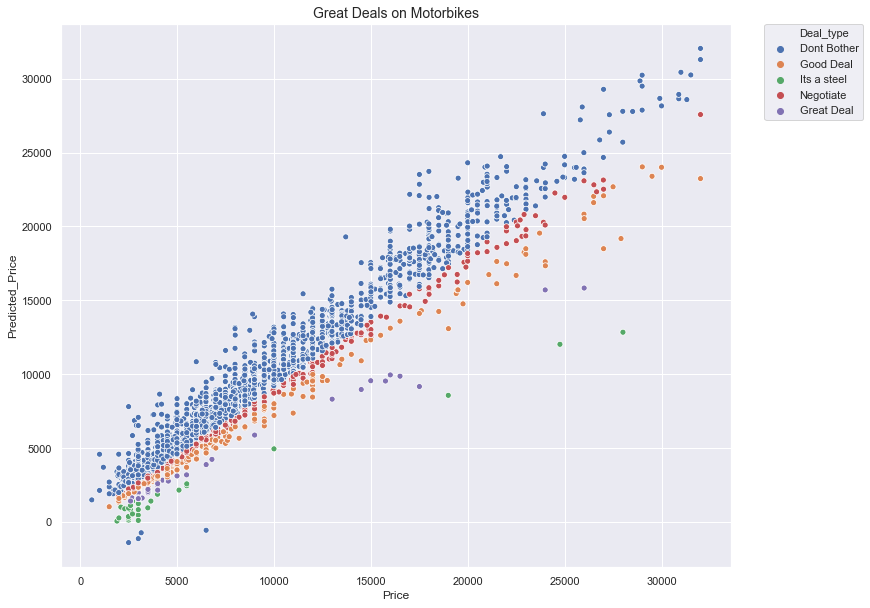

In [61]:
scatter(sport_df,'Price','Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')


In [65]:

sport_df[['Price','Predicted_Price','Price_ratio','Deal_type']][sport_df['Price'] > 15000].head(10)

,Price,Predicted_Price,Price_ratio,Deal_type
1127,15200.0,15759.525279,0.964496,Dont Bother
1128,15200.0,14589.409022,1.041852,Dont Bother
1129,15500.0,16538.555841,0.937204,Dont Bother
1130,15500.0,15214.666925,1.018754,Dont Bother
1131,15500.0,15797.216999,0.981185,Dont Bother
1132,15500.0,15704.481229,0.986979,Dont Bother
1133,15500.0,12636.441276,1.226611,Good Deal
1134,15500.0,13930.194993,1.112691,Negotiate
1135,15600.0,17881.927243,0.872389,Dont Bother
1136,15700.0,16525.186605,0.950065,Dont Bother


In [ ]:
model = RidgeCV(cv=5)

X = sport_df[features]
y = sport_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

n = X_train.shape[0]

best_score = 0
best_feature = ''
feature_set = features
included = []

# top 10 features
for i in range(10):

    for col in features_set:

        model.fit(X_train[included + [col]], y_train)
        r2 = model.score(X_test[included + [col]], y_test)

        score = adjusted_r2(r2,n,1) 

        if (score > best_score):
            best_score = score
            best_feature = col


    print ('Added ',best_feature)
    included.append(best_feature)
    # reset for the next round
    best_score = 0
    best_feature = ''
    feature_set = set(features) - set(included)

print (included)

In [23]:
model = LassoCV(cv=5)

X_train, X_test, y_train, y_test = train_test_split(sport_df[features], sport_df['Price'],
                                                    random_state=1, test_size=0.3)

#result = cross_val_score(model, scaleSport[model_cols], sport_df['Price'], cv=5, scoring='r2')
result = cross_val_score(model, X_train[model_cols], y_train, cv=5, scoring='r2')
result

array([0.75388828, 0.78876739, 0.79761285, 0.7969353 , 0.7364585 ])

In [25]:
result = cross_val_score(model, X_test[model_cols], y_test, cv=5, scoring='r2')
result

array([0.60100941, 0.63718051, 0.50006065, 0.70923495, 0.6166904 ])

In [24]:
result = cross_val_score(model, sport_df[features], sport_df['Price'], cv=5, scoring='r2')
result

array([-2.76386866, -1.98439363,  0.5310654 ,  0.64212447,  0.67558663])

In [321]:

def run_LinearModel(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    n, k = X_test.shape

    r2 = model.score(X_train,y_train)
    print ('Training: R2:',r2)
    print ('Training: adjusted R2',adjusted_r2(r2, n, k))

    r2 = model.score(X_test,y_test)
    print ('Testing: R2:',r2)
    print ('Testing: adjusted R2',adjusted_r2(r2, n, k))
    print ('mean_squared_error:',mean_squared_error(y_test,pred))
    
    return model, pred


def run_LassoCV(X_train, X_test, y_train, y_test,cv=5):
    model = LassoCV(cv=cv) 
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    n, k = X_test.shape

    r2 = model.score(X_train,y_train)
    print ('Training: R2:',r2)
    print ('Training: adjusted R2',adjusted_r2(r2, n, k))

    r2 = model.score(X_test,y_test)
    print ('Testing: R2:',r2)
    print ('Testing: adjusted R2',adjusted_r2(r2, n, k))
    print ('mean_squared_error:',mean_squared_error(y_test,pred))
    
    return model, pred


model, predictions = run_LassoCV(X_train, X_test, y_train, y_test)



Training: R2: 0.706419255150665
Training: adjusted R2 1.219095115870418
Testing: R2: 0.680765496934826
Testing: adjusted R2 1.2382401491446384
mean_squared_error: 12014464.15790585


# Determine which bikes are a good deal

This will be the bikes that have an advertised price lower than the predicted price. The determination of a good deal or not will be based on a threshold of the ratio of the advertised price to the predicted price.

In [323]:
model.fit(sport_df[features], sport_df['Price'])
sport_df['Predicted_Price'] = model.predict(sport_df[features])



In [324]:
# Tranasform the values back to standard meaning
sport_df[['Price','Predicted_Price']].head()

,Price,Predicted_Price
0,1500.0,-1719.187941
1,1700.0,2056.228071
2,1900.0,-3779.143691
3,1990.0,-1130.815868
4,1999.0,133.180327


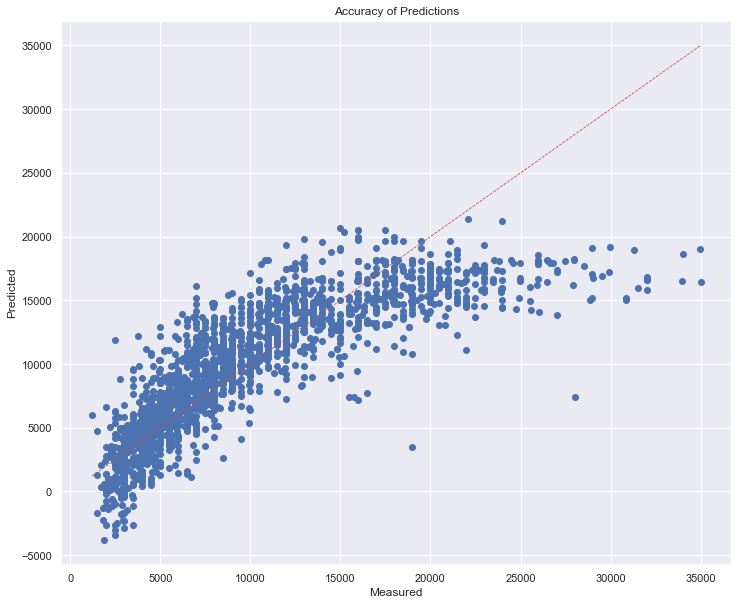

In [325]:
def plot_predictions(y_test,pred):
    fig, ax = plt.subplots(figsize=(12,10))
    ax.scatter(y_test,pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=0.8)
    ax.set_xlabel('Measured');
    ax.set_ylabel('Predicted');
    ax.set_title('Accuracy of Predictions');
    #ax.set_ylim(0,y_test.max());
    
plot_predictions(sport_df['Price'],sport_df['Predicted_Price'])

In [326]:
sport_df['Price_ratio'] = sport_df['Price'] / sport_df['Predicted_Price']

sport_df['Deal_type'] = 'Dont Bother'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.1] = 'Negotiate'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.2] = 'Good Deal'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.5] = 'Great Deal'
sport_df['Deal_type'][sport_df['Price_ratio'] > 2] = 'Its a steel'




In [328]:
def scatter(data,x,y,hue=None,title='',figsize=(12,10)):
    ax = plt.figure(figsize=figsize)
    sns.scatterplot(x=x,y=y,hue=hue,data=data);
    plt.title(title,fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.ylim(0,40000)


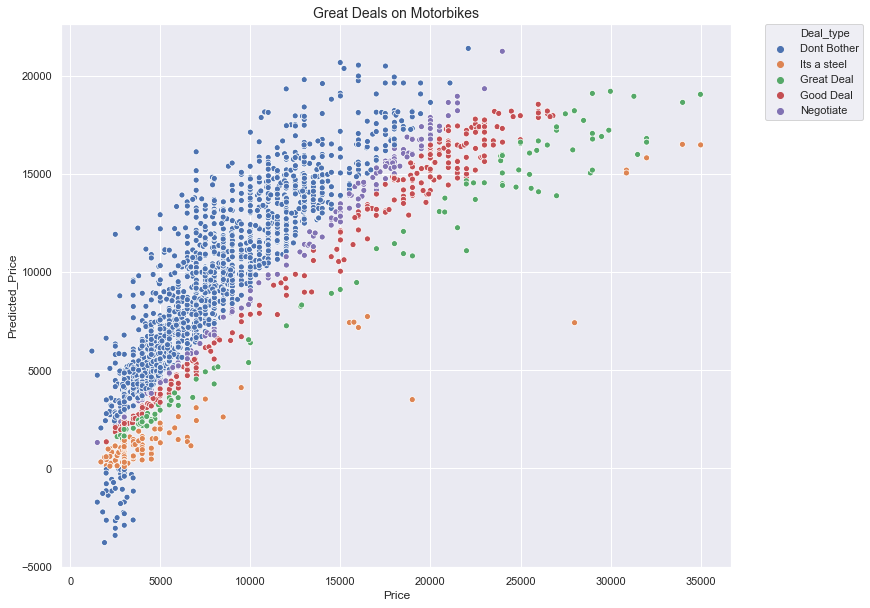

In [329]:
scatter(sport_df,'Price','Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')


In [228]:
outliers = sport_df[(sport_df['Predicted_Price'] > 40000) | (sport_df['Predicted_Price'] < 0)]


In [229]:
outliers[]

,Bore,Carburettor(s),Compression_Ratio,Cylinders,Dry_Weight,Engine_Description,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Reserve_Capacity,Fuel_Tank_Capacity,...,Model_f4 312 r 1000 11,Model_f4 750 s,Model_f4 750 s f4s 11,Model_f4 r,Model_f4 rr,Model_f4 rr 1000,Model_f4ago 1000,Predicted_Price,Price_ratio,Deal_type
9,57.0,1.0,10.000000,1.0,123.0,150.0,290.43605,158.312257,3.459387,12.0,...,0,0,0,0,0,0,0,-6.160000e+02,-3.246753e+00,Dont Bother
176,81.5,1.0,11.000000,2.0,200.0,650.0,300.00000,158.312257,3.459387,17.0,...,0,0,0,0,0,0,0,2.496419e+18,1.522181e-15,Dont Bother
351,97.0,1.0,11.000000,2.0,275.0,1000.0,320.00000,120.000000,4.000000,20.0,...,0,0,0,0,0,0,0,7.987703e+17,6.258370e-15,Dont Bother
421,97.0,1.0,11.000000,2.0,275.0,1000.0,320.00000,120.000000,4.000000,20.0,...,0,0,0,0,0,0,0,7.987703e+17,6.885584e-15,Dont Bother
563,53.5,2.0,10.463877,2.0,129.0,250.0,290.43605,158.312257,3.459387,15.0,...,0,0,0,0,0,0,0,2.017931e+17,3.434210e-14,Dont Bother
